Max Sharpe Ratio Portfolio Weights: OrderedDict([('ADAUSDT', 0.0), ('ALGOUSDT', 0.0), ('ATOMUSDT', 0.0), ('BATUSDT', 0.0), ('BCHUSDT', 0.0), ('BNBUSDT', 0.0), ('BTCUSDT', 0.14722), ('COMPUSDT', 0.0), ('DASHUSDT', 0.0), ('EOSUSDT', 0.0), ('ETCUSDT', 0.0), ('ETHUSDT', 0.0), ('IOSTUSDT', 0.0), ('IOTAUSDT', 0.0), ('KNCUSDT', 0.0), ('LINKUSDT', 0.0), ('LTCUSDT', 0.50371), ('NEOUSDT', 0.0), ('OMGUSDT', 0.00438), ('ONTUSDT', 0.02695), ('QTUMUSDT', 0.0), ('THETAUSDT', 0.0), ('TRXUSDT', 0.0), ('VETUSDT', 0.0), ('XLMUSDT', 0.0), ('XRPUSDT', 0.23622), ('XTZUSDT', 0.0), ('ZECUSDT', 0.0), ('ZILUSDT', 0.08151), ('ZRXUSDT', 0.0)])
Expected annual return: 50.8%
Annual volatility: 53.4%
Sharpe Ratio: 0.95
Min Volatility Portfolio Weights: OrderedDict([('ADAUSDT', 0.0), ('ALGOUSDT', 0.0), ('ATOMUSDT', 0.0), ('BATUSDT', 0.0), ('BCHUSDT', 0.0), ('BNBUSDT', 0.0), ('BTCUSDT', 0.0), ('COMPUSDT', 0.0), ('DASHUSDT', 0.0), ('EOSUSDT', 0.0), ('ETCUSDT', 0.0), ('ETHUSDT', 0.0), ('IOSTUSDT', 0.0), ('IOTAUSDT', 0.0

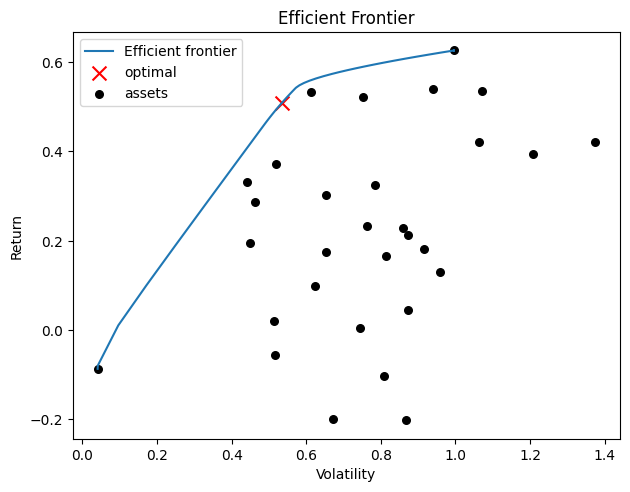

Assets above the optimal portfolio threshold:
KNCUSDT: 0.0007
NEOUSDT: 0.9964
TRXUSDT: 0.0026


In [4]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.cla import CLA
from pypfopt.plotting import plot_efficient_frontier
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

# Load historical data
data_dir = "../data"
symbols = [f.split('_')[0] for f in os.listdir(data_dir) if f.endswith('_historical.csv')]

# Function to load data for a symbol
def load_data(symbol):
    return pd.read_csv(f"{data_dir}/{symbol}_historical.csv")

# Combine closing prices into a single DataFrame
prices = pd.DataFrame()
for symbol in symbols:
    df = load_data(symbol)
    df['open_time'] = pd.to_datetime(df['open_time'])
    prices[symbol] = df.set_index('open_time')['close']

# Handle missing data by forward filling
prices.ffill(inplace=True)

# Calculate expected returns and covariance using robust models
mu = expected_returns.ema_historical_return(prices)  # Exponentially weighted mean historical return
S = risk_models.exp_cov(prices)  # Exponentially weighted covariance

# Optimize for maximal Sharpe ratio
try:
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    print("Max Sharpe Ratio Portfolio Weights:", cleaned_weights)
    ef.portfolio_performance(verbose=True)
except ValueError as e:
    print(f"Error during max Sharpe optimization: {e}")
    cleaned_weights = None

# Optimize for minimal volatility
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print("Min Volatility Portfolio Weights:", cleaned_weights)
ef.portfolio_performance(verbose=True)

# Calculate VaR (95%) and CVaR (95%) manually
def calculate_var_cvar(prices, weights, confidence_level=0.95):
    # Portfolio returns based on historical data
    portfolio_returns = prices.pct_change().dropna().dot(np.array(list(weights.values())))

    # Mean and standard deviation of portfolio returns
    mean = portfolio_returns.mean()
    std_dev = portfolio_returns.std()

    # VaR at the given confidence level
    var = norm.ppf(1 - confidence_level, mean, std_dev)

    # CVaR is the expected return below the VaR threshold
    cvar = portfolio_returns[portfolio_returns < var].mean()

    return var, cvar

# Calculate for the cleaned weights from min volatility portfolio
if cleaned_weights:
    var, cvar = calculate_var_cvar(prices, cleaned_weights)
    print(f"Value at Risk (VaR): {var:.2%}")
    print(f"Conditional Value at Risk (CVaR): {cvar:.2%}")

# Identify days with unusual returns
returns = prices.pct_change().dropna()
unusual_returns = returns[(returns > returns.mean() + 3 * returns.std()) | (returns < returns.mean() - 3 * returns.std())]
print(f"Days with unusual returns: {unusual_returns.dropna(how='all').shape[0]}")

# Plot efficient frontier
cla = CLA(mu, S)
ax = plot_efficient_frontier(cla, show_assets=True)
plt.title("Efficient Frontier")
plt.show()

# Identify assets in the optimal portfolio (above zero weight)
def get_assets_above_threshold(weights, threshold=0.0):
    return {asset: weight for asset, weight in weights.items() if weight > threshold}

if cleaned_weights:
    optimal_assets = get_assets_above_threshold(cleaned_weights)
    print("Assets above the optimal portfolio threshold:")
    for asset, weight in optimal_assets.items():
        print(f"{asset}: {weight:.4f}")

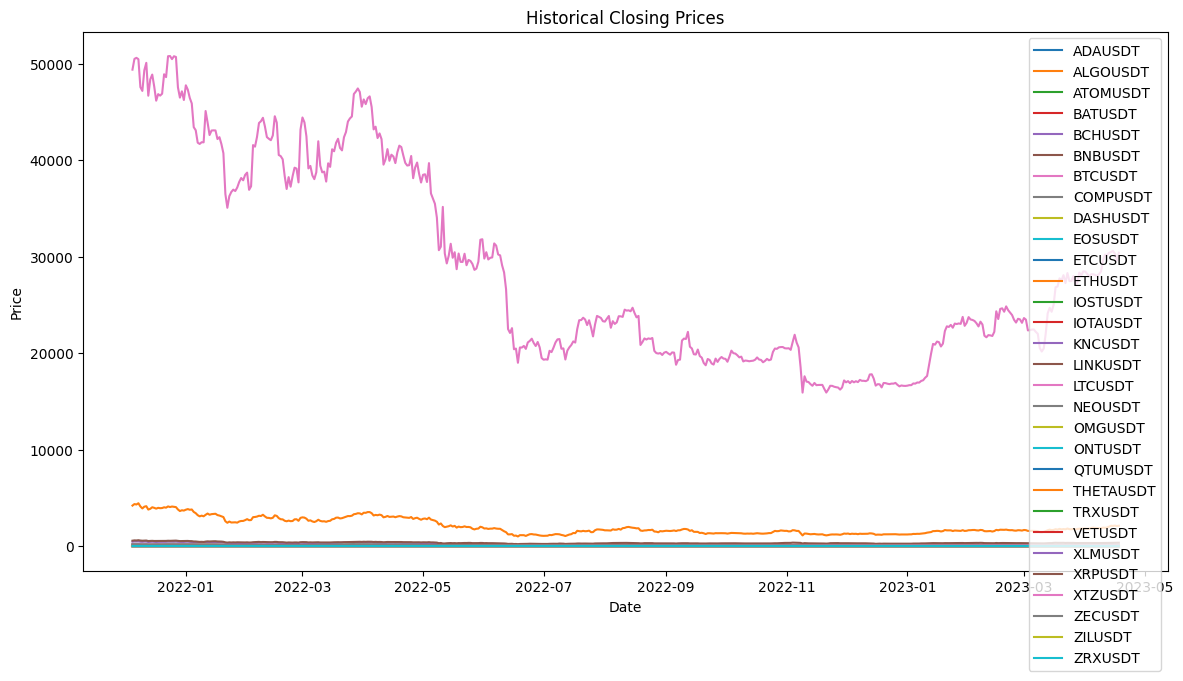

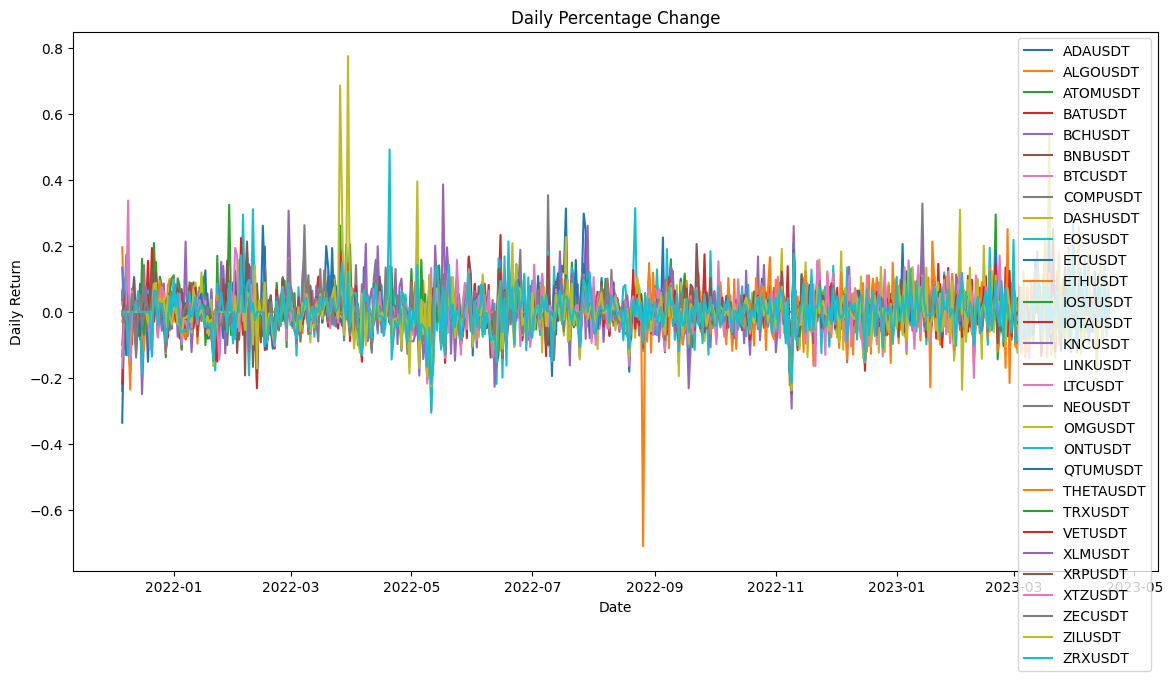

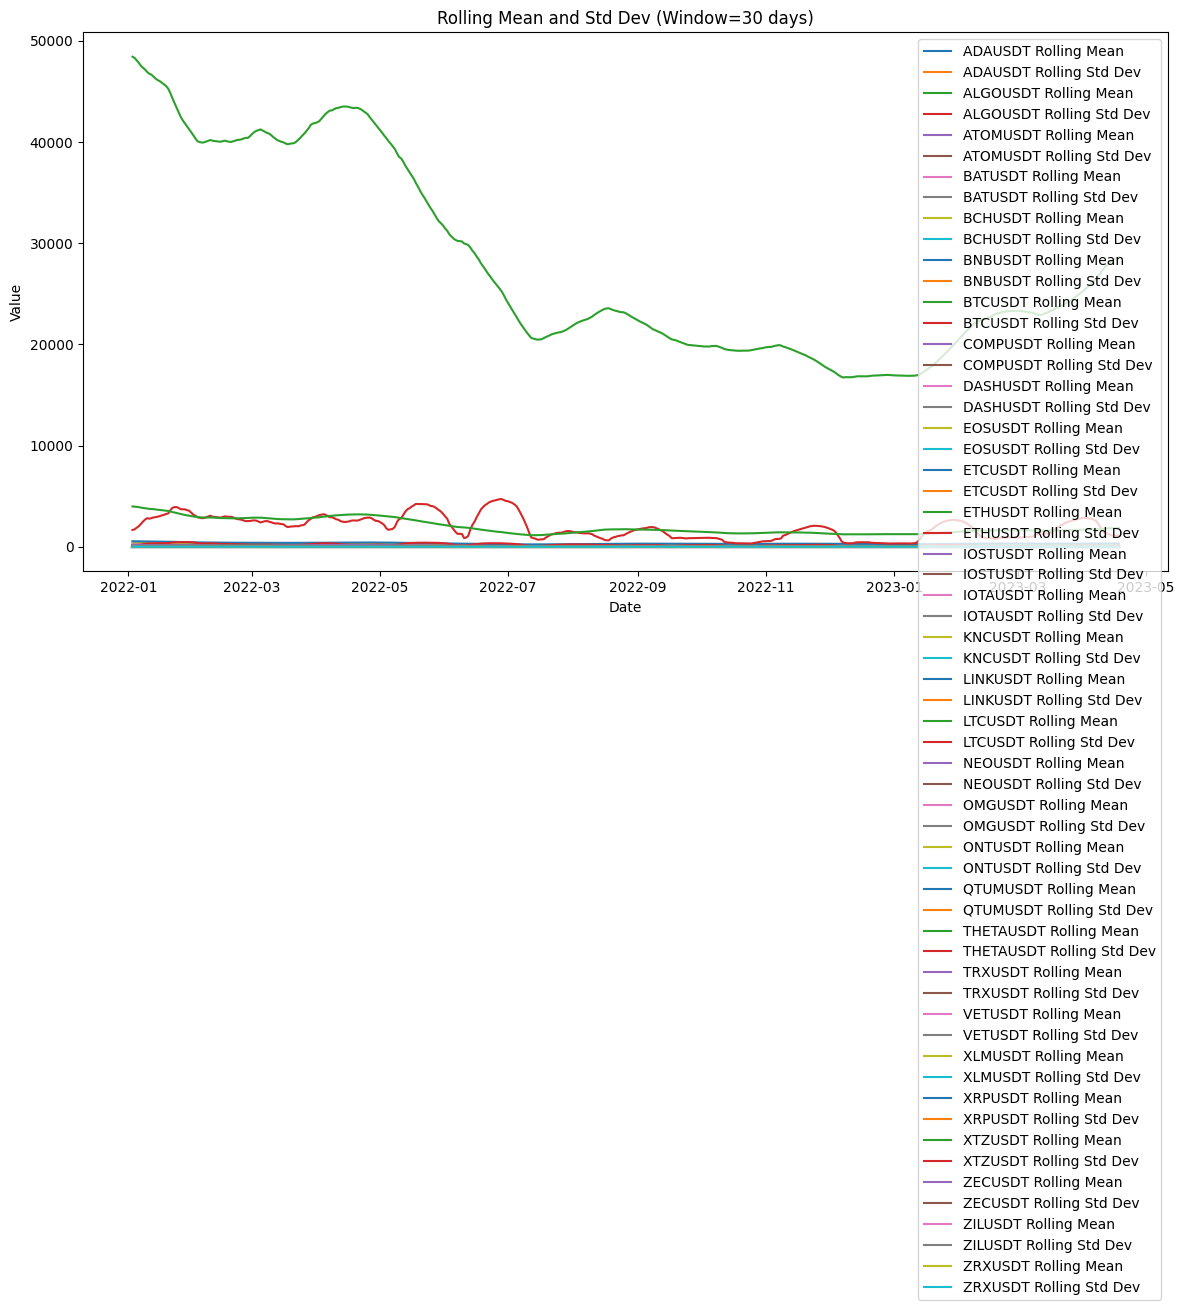

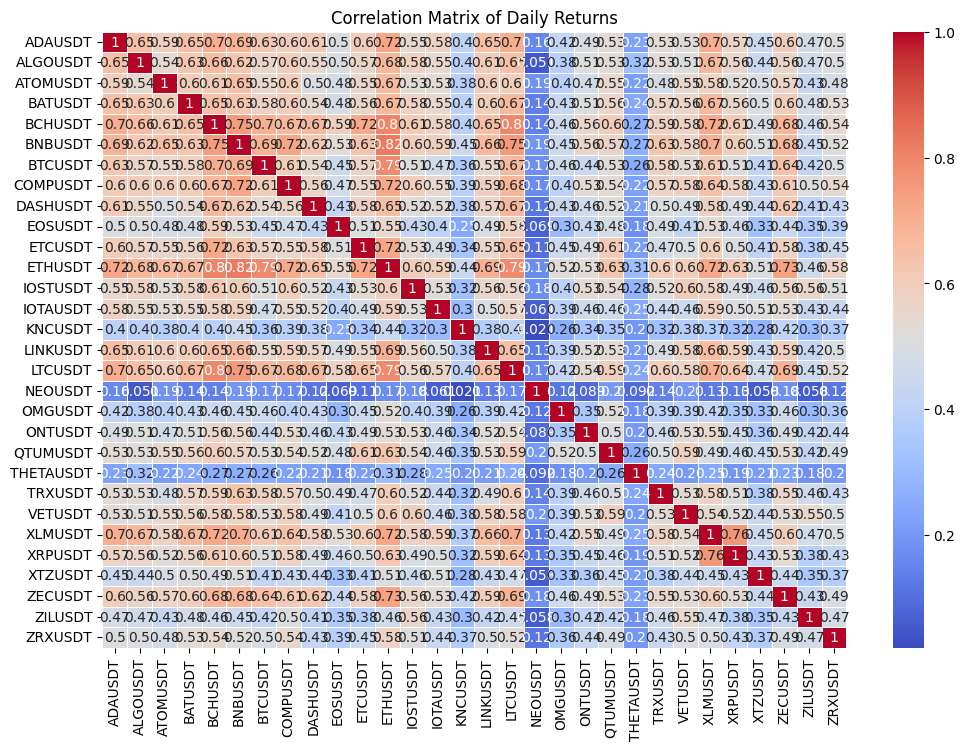

In [5]:
# Historical Price Trends
plt.figure(figsize=(14, 7))
for symbol in symbols:
    plt.plot(prices.index, prices[symbol], label=symbol)
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Daily Percentage Change
daily_returns = prices.pct_change().dropna()
plt.figure(figsize=(14, 7))
for symbol in symbols:
    plt.plot(daily_returns.index, daily_returns[symbol], label=symbol)
plt.title('Daily Percentage Change')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

# Rolling Statistics
rolling_window = 30
plt.figure(figsize=(14, 7))
for symbol in symbols:
    rolling_mean = prices[symbol].rolling(window=rolling_window).mean()
    rolling_std = prices[symbol].rolling(window=rolling_window).std()
    plt.plot(prices.index, rolling_mean, label=f'{symbol} Rolling Mean')
    plt.plot(prices.index, rolling_std, label=f'{symbol} Rolling Std Dev')
plt.title(f'Rolling Mean and Std Dev (Window={rolling_window} days)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Correlation Heatmap
import seaborn as sns

correlation_matrix = daily_returns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns')
plt.show()